### Задача uplift-моделирования

### Домашнее задание

1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention
2. там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.
3. сделать разбиение набора данных не тренировочную и тестовую выборки
4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)
5. провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями
6. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей
7. построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево
8. (опционально) для модели S learner (модель с дополнительным признаком коммуникации) построить зависимость таргета (конверсии - поле conversion) от значения uplift: 1) сделать прогноз и получить uplift для тестовой выборки 2) отсортировать тестовую выборку по uplift по убыванию 3) разбить на децили (pandas qcut вам в помощь) 4) для каждого дециля посчитать среднюю conversion
9. (опционально) построить модель UpliftRandomForestClassifier и попытаться описать словами полученное дерево

### Библиотеки и пакеты

1. causalml
2. sklift
3. catboost

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("data.csv")

In [2]:
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [3]:
df_new = df.rename(columns={'conversion': 'target', 'offer': 'treatment'})

df_new['treatment'].unique()

array(['Buy One Get One', 'No Offer', 'Discount'], dtype=object)

In [4]:
df_new['treatment'] = df_new['treatment'].replace({'Buy One Get One': 1, 'Discount': 1, 'No Offer': 0})

df_new['treatment']

0        1
1        0
2        1
3        1
4        1
        ..
63995    1
63996    1
63997    1
63998    1
63999    1
Name: treatment, Length: 64000, dtype: int64

In [5]:
df_new['channel'] = df_new['channel'].fillna(value='Не определен')

print(df_new['channel'].value_counts(dropna=False))

Web             28217
Phone           28021
Multichannel     7762
Name: channel, dtype: int64


In [6]:
del df_new['zip_code']

In [7]:
from sklearn.model_selection import train_test_split

stratify_cols = pd.concat([df_new.treatment, df_new.target], axis=1)

X_train, X_test, treat_train, treat_test, y_train, y_test = train_test_split(
    df_new,
    df_new.treatment,
    df_new.target,
    stratify=stratify_cols,
    test_size=0.3,
    random_state=42
)
cat_features = ['channel']
models_results = {
    'approach': [],
    'uplift@30%': []
}
models_results_20 = {
    'approach': [],
    'uplift@20%': []
}
models_results_10 = {
    'approach': [],
    'uplift@10%': []
}
print(f"Train shape: {X_train.shape}")
print(f"Validation shape: {X_test.shape}")

Train shape: (44800, 8)
Validation shape: (19200, 8)


In [8]:
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel

# sklift поддерживает любые модели, 
# которые удовлетворяют соглашениями scikit-learn
# Для примера воспользуемся catboost
from catboost import CatBoostClassifier


sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_sm = sm.predict(X_test)

sm_score = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.3)
print(f'uplift@30%: {sm_score:.4f}')

models_results['approach'].append('SoloModel')
models_results['uplift@30%'].append(sm_score)

uplift@30%: 0.2028


In [9]:
uplift_sm = sm.predict(X_test)

sm_score = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.2)
sm_score_ = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='overall', k=0.2)
print(f'uplift@20%: {sm_score:.4f}')
print(f'Overall_uplift@20%: {sm_score_:.4f}')

models_results_20['approach'].append('SoloModel')
models_results_20['uplift@20%'].append(sm_score)

uplift@20%: 0.3043
Overall_uplift@20%: 0.1292


In [10]:
uplift_sm = sm.predict(X_test)

sm_score = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.2)
sm_score_ = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='overall', k=0.2)
print(f'uplift@10%: {sm_score:.4f}')
print(f'Overall_uplift@10%: {sm_score_:.4f}')

models_results_10['approach'].append('SoloModel')
models_results_10['uplift@10%'].append(sm_score)

uplift@10%: 0.3043
Overall_uplift@10%: 0.1292


In [11]:
from sklift.models import TwoModels


tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

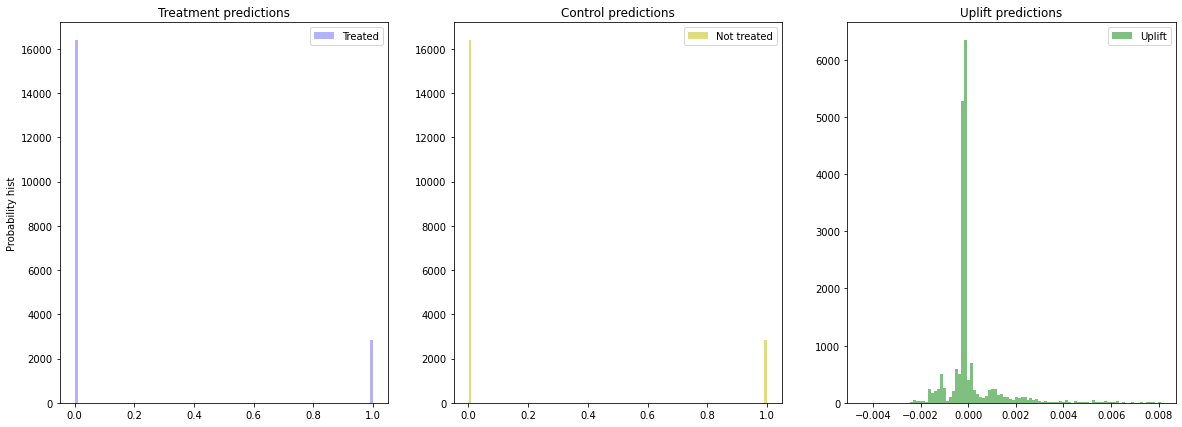

In [12]:
uplift_tm = tm.predict(X_test)

tm_score = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.3)

models_results['approach'].append('TwoModels')
models_results['uplift@30%'].append(tm_score)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

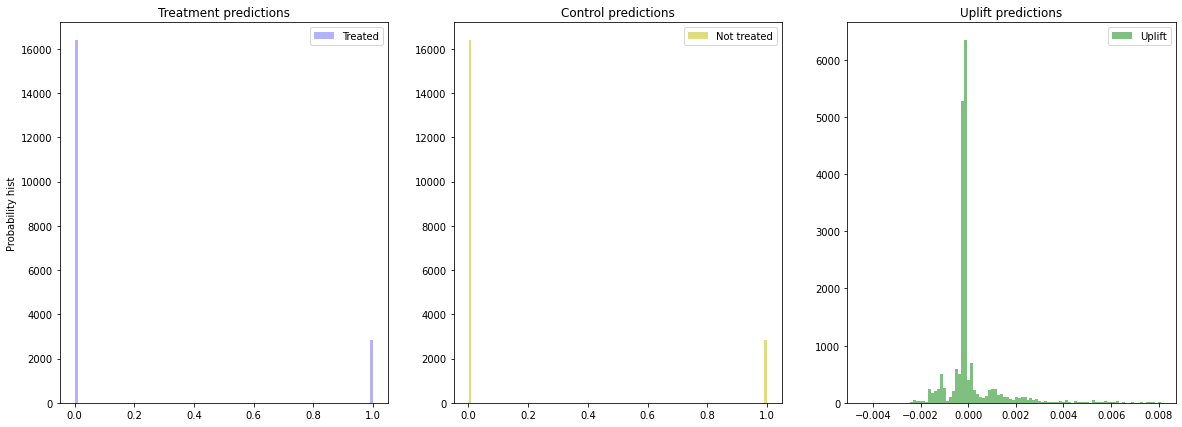

In [13]:
uplift_tm = tm.predict(X_test)

tm_score = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.2)

models_results_20['approach'].append('TwoModels')
models_results_20['uplift@20%'].append(tm_score)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

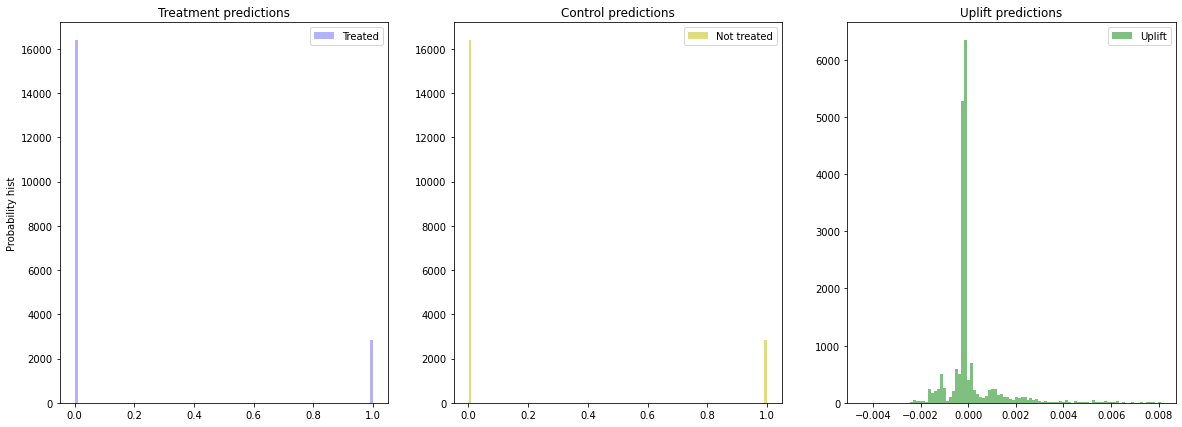

In [14]:
uplift_tm = tm.predict(X_test)

tm_score = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.1)

models_results_10['approach'].append('TwoModels')
models_results_10['uplift@10%'].append(tm_score)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);